# MNIST Neural Network
Around a year ago, I tried making a neural network to identify handwritten digits using mostly raw python. 

This time, I wanted to tackle the problem again with newfound knowledge of data science from a university course I took (CSC 177) alongside using PyTorch.

First we'll need to import various libraries with their functions. For this project, I'm using PyTorch, Pandas, Sklearn, and Matplotlib.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt

## Splitting and Preprocessing
Afterwards, we'll need to split the data into a training and validation set with an 80% training, 20% validation split.

For preprocessing, the dataset has no missing values, but we can instead normalize the data using min max scaling. It does not make sense to use something like standardization, so we instead use min max scaling to help the neural network avoid large weights and ensuring a consistent scale.

In [2]:
mnist_df = pd.read_csv('./data/mnist.csv')

X = mnist_df.drop('label', axis=1).to_numpy()
y = mnist_df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)

normalizer = preprocessing.MinMaxScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

## Neural Network
We'll make a neural network class and instantiate it. In the class constructor, we outline the structure of the neural network, which consists of 1 input layer, 3 hidden layers, and 1 output layer. The input layer has 784 neurons, since the training data consists of images that are 28x28 pixels. The hidden layers have 800, 130, and 80 neurons respectively. I got these numbers by tweaking them over time by measuring the accuracy and loss. Finally, the output layer has only 10 neurons, since there are only 10 digits that can be classified.

In [3]:
class MNIST_Neural_Network(nn.Module):
    def __init__(self, in_layer=784, hid_layer1=800, hid_layer2=130, hid_layer3=80, out_layer=10):
        super().__init__()
        self.w1 = nn.Linear(in_layer, hid_layer1)
        self.w2 = nn.Linear(hid_layer1, hid_layer2)
        self.w3 = nn.Linear(hid_layer2, hid_layer3)
        self.out = nn.Linear(hid_layer3, out_layer)
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = F.relu(self.w1(x))
        x = F.relu(self.w2(x))
        x = F.relu(self.w3(x))
        x = self.dropout(x)
        x = self.out(x)
        
        return x

In [4]:
mnist_model = MNIST_Neural_Network()

## Training
Now that the class has been instantiated, it needs to be trained. The training and validation data are converted into tensors. Then we use cross entropy loss for the criterion, which helps compute the gradient. Afterward, we also need to choose an optimizer, so I chose Adam due to its effectiveness and speed.

In [5]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_model.parameters(), lr=0.001)

Moving onto the training process, this loop will train the neural network by changing the weights accordingly and calculating the loss.

In [6]:
epochs = 200
losses = []

for i in range(epochs):
    # Forward propagation
    y_pred = mnist_model.forward(X_train)

    # Measure loss
    loss = criterion(y_pred, y_train)

    # Keep track of losses
    losses.append(loss.detach().numpy())

    # Print every 10 epochs
    if i % 10 == 0:
        print(f'Epoch {i}: loss = {loss}')

    
    # Back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Epoch 0: loss = 2.306936740875244
Epoch 10: loss = 1.532344102859497
Epoch 20: loss = 0.7366531491279602
Epoch 30: loss = 0.49133363366127014
Epoch 40: loss = 0.384723037481308
Epoch 50: loss = 0.3212299644947052
Epoch 60: loss = 0.2666409909725189
Epoch 70: loss = 0.22961214184761047
Epoch 80: loss = 0.19976656138896942
Epoch 90: loss = 0.17310698330402374
Epoch 100: loss = 0.1516944020986557
Epoch 110: loss = 0.12975788116455078
Epoch 120: loss = 0.11196891218423843
Epoch 130: loss = 0.09781689941883087
Epoch 140: loss = 0.08469421416521072
Epoch 150: loss = 0.07524450123310089
Epoch 160: loss = 0.06402426213026047
Epoch 170: loss = 0.05606229603290558
Epoch 180: loss = 0.04842311888933182
Epoch 190: loss = 0.040886785835027695


Also plotted the losses from the training step to visualize the loss after each epoch.

Text(0, 0.5, 'Loss')

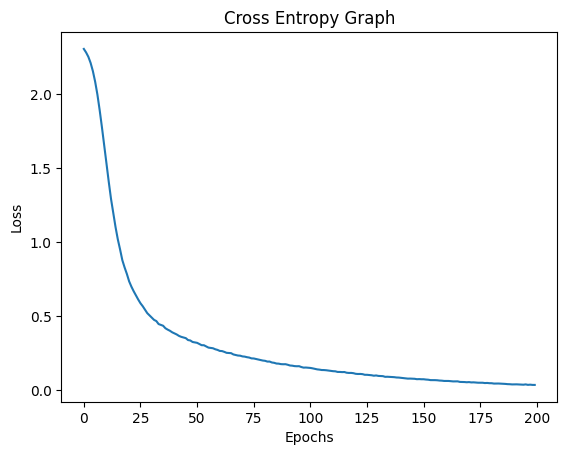

In [7]:
plt.plot(range(epochs), losses)
plt.title('Cross Entropy Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')

## Validation Data
After the model has been trained, it's time to apply it to the validation data.

In [8]:
with torch.no_grad():
    y_eval = mnist_model.forward(X_test)
    loss = criterion(y_eval, y_test) # get loss/error of y_eval

print(float(loss))

0.12597641348838806


## Basic Accuracy
After observing the loss from the model against validation data, we can move onto measuring the accuracy of both the training and validation data. I included the training data accuracy as another measure of checking for overfitting.

In [9]:
def test_mnist(X_data, y_data):
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(X_data):
            y_val = mnist_model.forward(data)

            if (torch.argmax(y_val) == y_data[i]):
                correct +=  1

    return (correct/len(y_data)) * 100

In [10]:
print(f'Training Data Accuracy:\t {test_mnist(X_train, y_train):.2f}%')
print(f'Test Data Accuracy:\t {test_mnist(X_test, y_test):.2f}%')

Training Data Accuracy:	 98.99%
Test Data Accuracy:	 96.73%


In [11]:
from PIL import Image
import torchvision.transforms as transforms

def predict_image(img_path):
    img = Image.open(img_path)

    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.PILToTensor(),
        ])

    img_tensor = transform(img).view(1, 28*28).float()

    img_tensor = F.normalize(img_tensor)

    mnist_model.eval()

    with torch.no_grad():
        output = mnist_model(img_tensor)
        predicted_label = torch.argmax(output).item()

    print(f'{str(img_path)[19:-4]}:\t{predicted_label}')

In [13]:
import os

img_folder = './data/test_images/'

for filename in os.listdir(img_folder):
    if filename.endswith('.jpg'):
        image_path = os.path.join(img_folder, filename)
        predict_image(image_path)

0-1:	0
0:	0
1:	1
2-1:	2
2:	2
3:	3
4-2:	4
4:	4
5:	5
6-1:	6
6:	6
7-1:	7
7:	7
8:	8
9:	9
